In [1]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [4]:
import hyperopt.pyll.stochastic
from sklearn.ensemble import RandomForestClassifier

In [10]:
import datetime
import numpy as np
from numpy.random import RandomState
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
import matplotlib.pyplot as plt 
from hyperopt import fmin,hp,Trials,space_eval,rand,tpe,anneal
import warnings 
warnings.filterwarnings('ignore')

def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(info+'...\n\n')

In [11]:
printlog("step1: reading data...")

# 读取dftrain,dftest
breast = datasets.load_breast_cancer()
df = pd.DataFrame(breast.data,
                  columns = [x.replace(' ','_') for x in breast.feature_names])
df['label'] = breast.target
df['mean_radius'] = df['mean_radius'].apply(lambda x:int(x))
df['mean_texture'] = df['mean_texture'].apply(lambda x:int(x))
dftrain,dftest = train_test_split(df)

categorical_features = ['mean_radius','mean_texture']
lgb_train = lgb.Dataset(dftrain.drop(['label'],axis = 1),label=dftrain['label'],
                        categorical_feature = categorical_features,free_raw_data=False)

lgb_valid = lgb.Dataset(dftest.drop(['label'],axis = 1),label=dftest['label'],
                        categorical_feature = categorical_features,
                        reference=lgb_train,free_raw_data=False)


================================================================================2022-07-27 18:28:27
step1: reading data......




In [13]:
printlog("step2: searching parameters...")
boost_round = 1000                   
early_stop_rounds = 50

params = {
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',#'dart','rf'  
    'objective':'binary',
    'metric': ['auc'],
    'num_leaves': 31,
    'max_depth':  6,
    'min_data_in_leaf': 5,  
    'min_gain_to_split': 0,
    'reg_alpha':0,
    'reg_lambda':0,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_pre_filter':False,
    'verbose': -1
}



================================================================================2022-07-27 18:28:39
step2: searching parameters......




In [15]:
def hyperopt_objective(config):
    params.update(config)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round= boost_round,
                    valid_sets=(lgb_valid, lgb_train),
                    valid_names=('validate','train'),
                    early_stopping_rounds = early_stop_rounds,
                    verbose_eval = False)
    y_pred_test = gbm.predict(dftest.drop('label',axis = 1),
                              num_iteration=gbm.best_iteration)
    val_score = f1_score(dftest['label'],y_pred_test>0.5)
    return -val_score


In [16]:
def hyperopt_objective(config):
    params.update(config)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round= boost_round,
                    valid_sets=(lgb_valid, lgb_train),
                    valid_names=('validate','train'),
                    early_stopping_rounds = early_stop_rounds,
                    verbose_eval = False)
    num_round = 10
    res = lgb.cv(params,  # 如果lgb.LGBMRegressor.get_params()
                 lgb_train,
                 num_round,
                 nfold=5,
                 metrics='auc',
                 early_stopping_rounds=10)
    
    return min(res['auc-mean'])

In [17]:
#可以根据需要，注释掉偏后的一些不太重要的超参
spaces = {"learning_rate":hp.loguniform("learning_rate",np.log(0.001),np.log(0.5)),
          "boosting_type":hp.choice("boosting_type",['gbdt','dart','rf']),
          "num_leaves":hp.choice("num_leaves",range(15,128)),
          #"max_depth":hp.choice("max_depth",range(3,11)),
          #"min_data_in_leaf":hp.choice("min_data_in_leaf",range(1,50)),
          #"min_gain_to_split":hp.uniform("min_gain_to_split",0.0,1.0),
          #"reg_alpha": hp.uniform("reg_alpha", 0, 2),
          #"reg_lambda": hp.uniform("reg_lambda", 0, 2),
          #"feature_fraction":hp.uniform("feature_fraction",0.5,1.0),
          #"bagging_fraction":hp.uniform("bagging_fraction",0.5,1.0),
          #"bagging_freq":hp.choice("bagging_freq",range(1,20))
          }

In [20]:
# hyperopt支持如下搜索算法
#随机搜索(hyperopt.rand.suggest)
#模拟退火(hyperopt.anneal.suggest)
#TPE算法（hyperopt.tpe.suggest，算法全称为Tree-structured Parzen Estimator Approach）
trials = Trials()
best = fmin(fn=hyperopt_objective, 
            space=spaces, 
            algo= tpe.suggest, 
            max_evals=100, 
            trials=trials,
         rstate=RandomState(123))

100%|████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09trial/s, best loss: 0.94582681719303]


In [21]:
best_params = space_eval(spaces,best)
print("best_params = ",best_params)

best_params =  {'boosting_type': 'dart', 'learning_rate': 0.011075468308122444, 'num_leaves': 110}


Text(0, 0.5, 'loss')

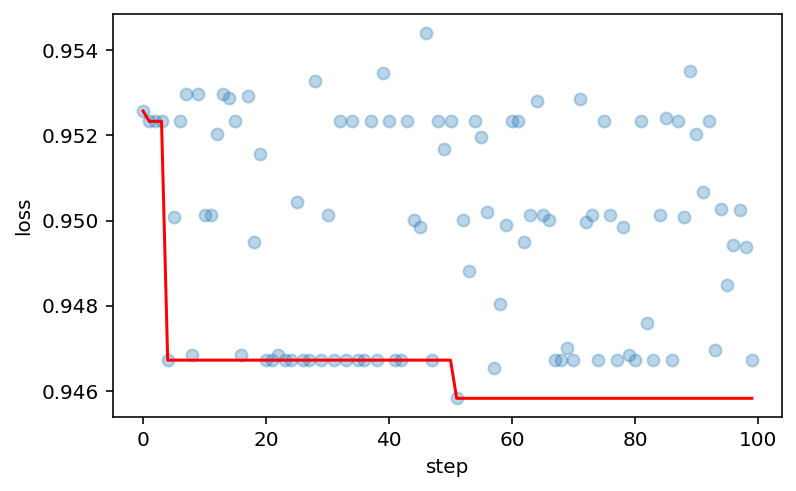

In [22]:
losses = [x["result"]["loss"] for x in trials.trials]
minlosses = [np.min(losses[0:i+1]) for i in range(len(losses))] 
steps = range(len(losses))

fig,ax = plt.subplots(figsize=(6,3.7),dpi=144)
ax.scatter(x = steps, y = losses, alpha = 0.3)
ax.plot(steps,minlosses,color = "red",axes = ax)
plt.xlabel("step")
plt.ylabel("loss")

In [26]:
printlog("step3: training model...")

params.update(best_params)
results = {}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round= boost_round,
                valid_sets=(lgb_valid, lgb_train),
                valid_names=('validate','train'),
                early_stopping_rounds = early_stop_rounds,
                evals_result= results,
                verbose_eval = True)



================================================================================2022-07-27 18:33:51
step3: training model......


[1]	train's auc: 0.989541	validate's auc: 0.980713
[2]	train's auc: 0.996973	validate's auc: 0.986164
[3]	train's auc: 0.997456	validate's auc: 0.986897
[4]	train's auc: 0.997232	validate's auc: 0.987317
[5]	train's auc: 0.998316	validate's auc: 0.986373
[6]	train's auc: 0.998846	validate's auc: 0.986792
[7]	train's auc: 0.999317	validate's auc: 0.985325
[8]	train's auc: 0.999317	validate's auc: 0.985115
[9]	train's auc: 0.999317	validate's auc: 0.984906
[10]	train's auc: 0.999199	validate's auc: 0.984277
[11]	train's auc: 0.999458	validate's auc: 0.984277
[12]	train's auc: 0.999435	validate's auc: 0.984277
[13]	train's auc: 0.999411	validate's auc: 0.984067
[14]	train's auc: 0.999364	validate's auc: 0.983857
[15]	train's auc: 0.999246	validate's auc: 0.983438
[16]	train's auc: 0.99927	validate's auc: 0.992243
[17]	train's auc: 0.999293	validate's auc: 0.99

[271]	train's auc: 0.999976	validate's auc: 0.993082
[272]	train's auc: 0.999976	validate's auc: 0.993082
[273]	train's auc: 0.999976	validate's auc: 0.993082
[274]	train's auc: 0.999976	validate's auc: 0.993082
[275]	train's auc: 0.999953	validate's auc: 0.993082
[276]	train's auc: 0.999953	validate's auc: 0.993082
[277]	train's auc: 0.999953	validate's auc: 0.993082
[278]	train's auc: 0.999953	validate's auc: 0.993082
[279]	train's auc: 0.999953	validate's auc: 0.993082
[280]	train's auc: 0.999953	validate's auc: 0.993082
[281]	train's auc: 0.999953	validate's auc: 0.993082
[282]	train's auc: 0.999976	validate's auc: 0.993082
[283]	train's auc: 0.999976	validate's auc: 0.993082
[284]	train's auc: 0.999976	validate's auc: 0.993082
[285]	train's auc: 0.999976	validate's auc: 0.993082
[286]	train's auc: 0.999976	validate's auc: 0.992872
[287]	train's auc: 0.999976	validate's auc: 0.992872
[288]	train's auc: 0.999976	validate's auc: 0.992872
[289]	train's auc: 1	validate's auc: 0.992872


[565]	train's auc: 1	validate's auc: 0.993082
[566]	train's auc: 1	validate's auc: 0.993082
[567]	train's auc: 1	validate's auc: 0.993082
[568]	train's auc: 1	validate's auc: 0.993082
[569]	train's auc: 1	validate's auc: 0.993082
[570]	train's auc: 1	validate's auc: 0.993082
[571]	train's auc: 1	validate's auc: 0.993082
[572]	train's auc: 1	validate's auc: 0.993082
[573]	train's auc: 1	validate's auc: 0.993082
[574]	train's auc: 1	validate's auc: 0.993082
[575]	train's auc: 1	validate's auc: 0.993082
[576]	train's auc: 1	validate's auc: 0.993082
[577]	train's auc: 1	validate's auc: 0.993082
[578]	train's auc: 1	validate's auc: 0.993082
[579]	train's auc: 1	validate's auc: 0.993082
[580]	train's auc: 1	validate's auc: 0.993082
[581]	train's auc: 1	validate's auc: 0.993082
[582]	train's auc: 1	validate's auc: 0.993082
[583]	train's auc: 1	validate's auc: 0.993082
[584]	train's auc: 1	validate's auc: 0.993082
[585]	train's auc: 1	validate's auc: 0.993082
[586]	train's auc: 1	validate's au

[815]	train's auc: 1	validate's auc: 0.993711
[816]	train's auc: 1	validate's auc: 0.99392
[817]	train's auc: 1	validate's auc: 0.99392
[818]	train's auc: 1	validate's auc: 0.99392
[819]	train's auc: 1	validate's auc: 0.99392
[820]	train's auc: 1	validate's auc: 0.99392
[821]	train's auc: 1	validate's auc: 0.99392
[822]	train's auc: 1	validate's auc: 0.99392
[823]	train's auc: 1	validate's auc: 0.99392
[824]	train's auc: 1	validate's auc: 0.99413
[825]	train's auc: 1	validate's auc: 0.99413
[826]	train's auc: 1	validate's auc: 0.99413
[827]	train's auc: 1	validate's auc: 0.99413
[828]	train's auc: 1	validate's auc: 0.99413
[829]	train's auc: 1	validate's auc: 0.99413
[830]	train's auc: 1	validate's auc: 0.99413
[831]	train's auc: 1	validate's auc: 0.99413
[832]	train's auc: 1	validate's auc: 0.99413
[833]	train's auc: 1	validate's auc: 0.99413
[834]	train's auc: 1	validate's auc: 0.99413
[835]	train's auc: 1	validate's auc: 0.99413
[836]	train's auc: 1	validate's auc: 0.99413
[837]	tra


================================================================================2022-07-27 18:33:57
step4: evaluating model ......


train f1_score: 1.0 
valid f1_score: 0.97727 



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

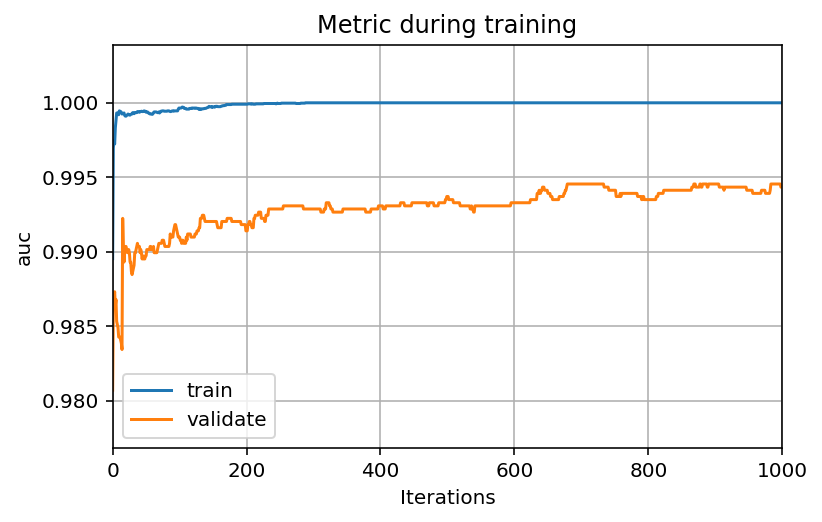

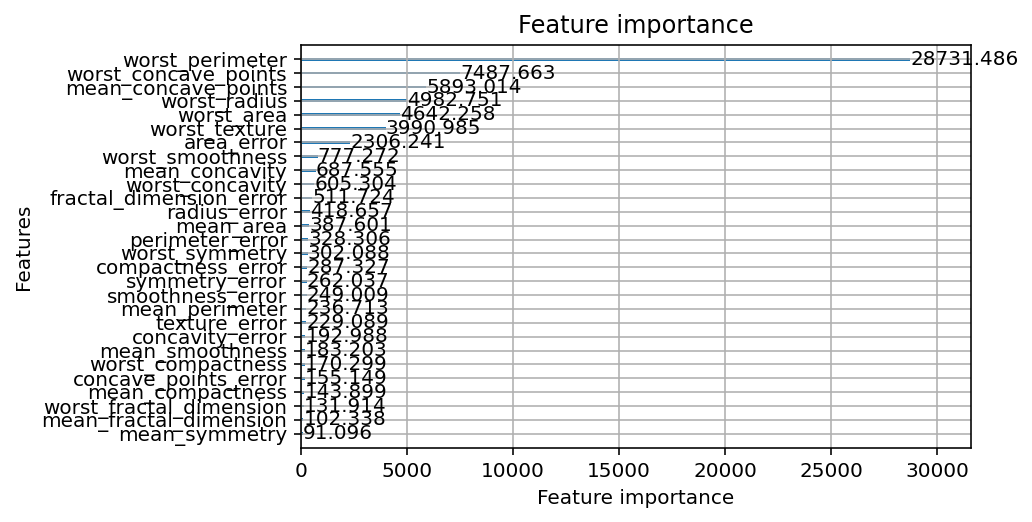

In [27]:
printlog("step4: evaluating model ...")

y_pred_train = gbm.predict(dftrain.drop('label',axis = 1), num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(dftest.drop('label',axis = 1), num_iteration=gbm.best_iteration)

train_score = f1_score(dftrain['label'],y_pred_train>0.5)
val_score = f1_score(dftest['label'],y_pred_test>0.5)

print('train f1_score: {:.5} '.format(train_score))
print('valid f1_score: {:.5} \n'.format(val_score))

fig2,ax2 = plt.subplots(figsize=(6,3.7),dpi=144)
fig3,ax3 = plt.subplots(figsize=(6,3.7),dpi=144)
lgb.plot_metric(results,ax = ax2)
lgb.plot_importance(gbm,importance_type = "gain",ax=ax3)